In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


In [ ]:
# Crear carpetas para resultados y figuras
import os
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Cargar datos
data_path = 'C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-processed.csv'
data = pd.read_csv(data_path, sep=',')
print(data.shape)

# Separar características y variable objetivo
X = data.drop(columns=['y'])
y = data['y']

# Definir columnas numéricas
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Escalar columnas numéricas
scale = MinMaxScaler()
X[numeric_cols] = scale.fit_transform(X[numeric_cols])

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

(45211, 33)


In [12]:
# Aplicar SMOTEENN para balancear clases
smoteenn = SMOTEENN(random_state=42)
X_resample, y_resample = smoteenn.fit_resample(X_train, y_train)
X_resample = pd.DataFrame(X_resample, columns=X.columns)
y_resample = pd.Series(y_resample)

In [13]:
# Selección de características con BorutaPy
rf = xgb.XGBClassifier(eval_metric='logloss')
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
feat_selector.fit(X_resample.values, y_resample.values.ravel())
X_filtered = X.columns[feat_selector.support_].tolist()
print(f"Selected features: {len(X_filtered)}")

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Selected features: 26


In [ ]:
# Filtrar datos con las características seleccionadas
X_train_filtered = X_resample[X_filtered].values
X_test_filtered = X_test[X_filtered].values
y_train_filtered = y_resample.values
y_test_filtered = y_test.values

In [ ]:
# Parámetros de la red neuronal
input_size = len(X_filtered)
hidden_units = 64
hidden_layers = 2
dropout_rate = 0.2
learning_rate = 0.0001
epochs = 50

batch_size = 32
# TODO: Modificar uno a la vez
num_microbatches = 32 # Probar otros valores
l2_norm_clip = 1.0 # Probar otros valores
noise_multiplier = 1.1 # Aumentarlo
n_iterations = 5

# Calcular el presupuesto de privacidad (ε, δ)
n = len(X_train_filtered)
delta = 1e-5
try:
    # En tensorflow-privacy 0.5.0, compute_dp_sgd_privacy tiene un argumento diferente
    eps = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
        n=n,
        batch_size=batch_size,
        noise_multiplier=noise_multiplier,
        epochs=epochs,
        delta=delta
    )[0]  # Retorna una tupla (eps, optimal_alpha), tomamos eps
    print(f"Presupuesto de privacidad: ε={eps:.2f}, δ={delta}")
except Exception as e:
    print(f"Error al calcular el presupuesto de privacidad: {e}")
    eps = float('inf')


DP-SGD with sampling rate = 0.0598% and noise_multiplier = 1.1 iterated over 83600 steps satisfies differential privacy with eps = 1.06 and delta = 1e-05.
The optimal RDP order is 17.0.
Presupuesto de privacidad: ε=1.06, δ=1e-05


In [22]:
# Definir la red neuronal con tf.keras
def create_model(input_size, hidden_units, hidden_layers, dropout_rate, use_dp=False):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(input_size,)))
    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilar el modelo
    if use_dp:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate
        )
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Función para entrenar el modelo
def train_model(X_train, y_train, X_test, y_test, batch_size, epochs, use_dp=False):
    model = create_model(input_size, hidden_units, hidden_layers, dropout_rate, use_dp=use_dp)
    
    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test)
    )
    
    # Predicciones
    y_pred_prob_test = model.predict(X_test, batch_size=batch_size).flatten()
    y_pred_test = (y_pred_prob_test > 0.4).astype(int)
    
    return y_pred_prob_test, y_pred_test

# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, y_pred_prob):
    conf_matrix = confusion_matrix(y_true, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_rate = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_rate = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_true, y_pred_prob),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Type I Error': false_positive_rate,
        'Type II Error': false_negative_rate
    }

# Función para ejecutar múltiples iteraciones y calcular estadísticas
def run_iterations(X_train, y_train, X_test, y_test, batch_size, epochs, use_dp, n_iterations):
    results = []
    for _ in range(n_iterations):
        y_pred_prob_test, y_pred_test = train_model(
            X_train, y_train, X_test, y_test, batch_size, epochs, use_dp=use_dp
        )
        result = evaluate_model(y_test, y_pred_test, y_pred_prob_test)
        results.append(result)
    return pd.DataFrame(results)

# Función para calcular estadísticas (promedio, mínimo, máximo)
def compute_statistics(df):
    stats = {
        'mean': df.mean(),
        'min': df.min(),
        'max': df.max()
    }
    return stats

In [23]:
# Ejecutar iteraciones para cada modelo
print("Entrenando modelo sin DP...")
results_no_dp = run_iterations(
    X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered, 
    batch_size, epochs, use_dp=False, n_iterations=n_iterations
)
results_no_dp_stats = compute_statistics(results_no_dp)


Entrenando modelo sin DP...
Epoch 1/50
1672/1672 [==============================] - 1s 640us/step - loss: 0.5824 - accuracy: 0.6913 - val_loss: 0.5829 - val_accuracy: 0.6835
Epoch 2/50
1672/1672 [==============================] - 1s 443us/step - loss: 0.4615 - accuracy: 0.7842 - val_loss: 0.5246 - val_accuracy: 0.7441
Epoch 3/50
1672/1672 [==============================] - 1s 440us/step - loss: 0.3784 - accuracy: 0.8395 - val_loss: 0.5178 - val_accuracy: 0.7806
Epoch 4/50
1672/1672 [==============================] - 1s 437us/step - loss: 0.3210 - accuracy: 0.8750 - val_loss: 0.4562 - val_accuracy: 0.8280
Epoch 5/50
1672/1672 [==============================] - 1s 452us/step - loss: 0.2895 - accuracy: 0.8903 - val_loss: 0.4550 - val_accuracy: 0.8304
Epoch 6/50
1672/1672 [==============================] - 1s 448us/step - loss: 0.2736 - accuracy: 0.8971 - val_loss: 0.4654 - val_accuracy: 0.8280
Epoch 7/50
1672/1672 [==============================] - 1s 479us/step - loss: 0.2655 - accuracy:

In [24]:
print("\nEntrenando modelo con DP...")
results_dp = run_iterations(
    X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered, 
    batch_size, epochs, use_dp=True, n_iterations=n_iterations
)
results_dp_stats = compute_statistics(results_dp)


Entrenando modelo con DP...
Epoch 1/50
1672/1672 [==============================] - 1s 440us/step - loss: 0.7369 - accuracy: 0.5057 - val_loss: 0.6912 - val_accuracy: 0.5204
Epoch 2/50
1672/1672 [==============================] - 1s 441us/step - loss: 0.6938 - accuracy: 0.5392 - val_loss: 0.7001 - val_accuracy: 0.4761
Epoch 3/50
1672/1672 [==============================] - 1s 447us/step - loss: 0.6845 - accuracy: 0.5610 - val_loss: 0.6947 - val_accuracy: 0.5127
Epoch 4/50
1672/1672 [==============================] - 1s 539us/step - loss: 0.6793 - accuracy: 0.5724 - val_loss: 0.6891 - val_accuracy: 0.5565
Epoch 5/50
1672/1672 [==============================] - 1s 457us/step - loss: 0.6737 - accuracy: 0.5858 - val_loss: 0.6877 - val_accuracy: 0.5626
Epoch 6/50
1672/1672 [==============================] - 1s 503us/step - loss: 0.6690 - accuracy: 0.5955 - val_loss: 0.6820 - val_accuracy: 0.5855
Epoch 7/50
1672/1672 [==============================] - 1s 473us/step - loss: 0.6642 - accuracy

In [25]:
# Guardar resultados en un CSV
results_stats = {
    'No DP': results_no_dp_stats,
    f'DP (ε={eps:.2f})': results_dp_stats
}
data = {}
for model, stats in results_stats.items():
    data[f'{model} (mean)'] = stats['mean']
    data[f'{model} (min)'] = stats['min']
    data[f'{model} (max)'] = stats['max']
results_df = pd.DataFrame(data).round(4)
results_df.to_csv('results/CDP_results.csv')
print("\nResultados guardados en 'results/CDP_results.csv'")
print("\nResultados (Promedios):\n", results_df[[col for col in results_df.columns if 'mean' in col]])



Resultados guardados en 'results/CDP_results.csv'

Resultados (Promedios):
                No DP (mean)  DP (ε=1.06) (mean)
ROC AUC              0.9009              0.7338
Accuracy             0.8099              0.4978
Precision            0.3662              0.1689
Recall               0.8543              0.8389
F1 Score             0.5126              0.2811
Type I Error         0.1960              0.5474
Type II Error        0.1457              0.1611


In [26]:
# Gráficas
def plot_results_with_whiskers(stats_dict, title, colors):
    metrics = list(stats_dict['No DP']['mean'].keys())
    models = list(stats_dict.keys())
    n_metrics = len(metrics)
    n_models = len(models)
    
    plt.figure(figsize=(12, 6))
    x_positions = np.arange(n_metrics)
    
    for model_idx, model in enumerate(models):
        means = []
        mins = []
        maxs = []
        for metric in metrics:
            means.append(stats_dict[model]['mean'][metric])
            mins.append(stats_dict[model]['min'][metric])
            maxs.append(stats_dict[model]['max'][metric])
        
        plt.scatter(x_positions + (model_idx - (n_models-1)/2) * 0.15, means, 
                    color=colors[model_idx], label=model, s=100)
        for metric_idx in range(n_metrics):
            plt.vlines(x_positions[metric_idx] + (model_idx - (n_models-1)/2) * 0.15, 
                       mins[metric_idx], maxs[metric_idx], 
                       color=colors[model_idx], linestyle='-', linewidth=1)
    
    plt.xticks(x_positions, metrics, rotation=45)
    plt.title(title)
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'figures/{title.replace(" ", "_").replace("=", "")}.jpg', dpi=300, bbox_inches='tight')
    plt.show()

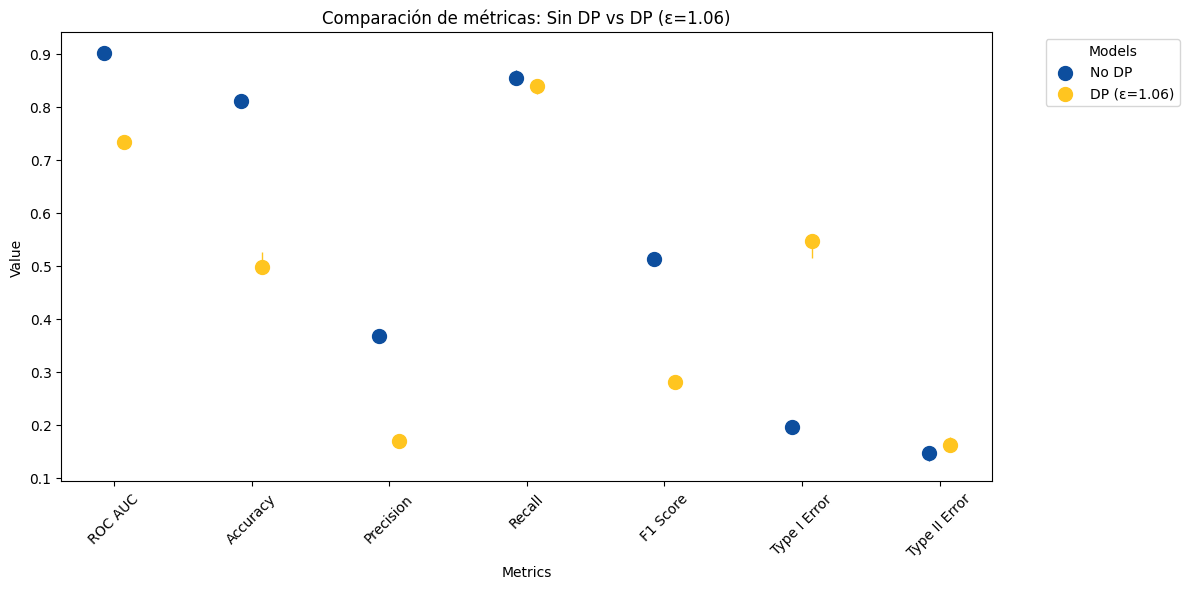

In [27]:
# Colores para los modelos
colores = ['#0d4e9e', '#ffc520']

# Graficar resultados
plot_results_with_whiskers(results_stats, f'Comparación de métricas: Sin DP vs DP (ε={eps:.2f})', colores)